# dcgan

In [1]:
import numpy as np

data = np.load('data/electrons_log', encoding='latin1')

In [7]:
data = np.load('data/electrons_log', encoding='latin1')
real_data = np.exp(data)
tanh_data = np.tanh(real_data)

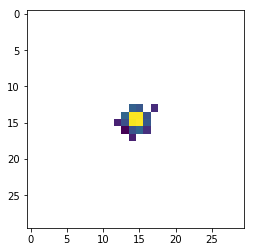

In [3]:
import scipy.misc
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure()
plt.imshow(data[0])

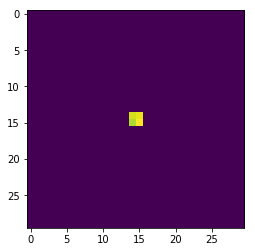

In [4]:
plt.figure()
plt.imshow(real_data[0])

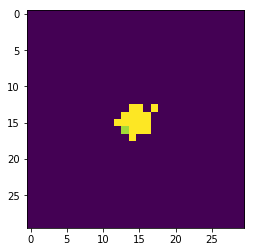

In [5]:
tanh_data = np.tanh(real_data)

plt.figure()
plt.imshow(tanh_data[0])

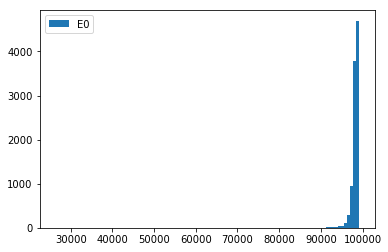

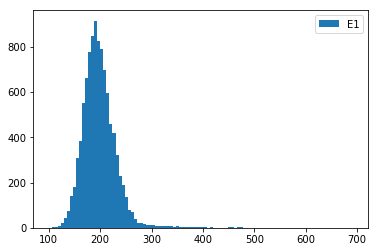

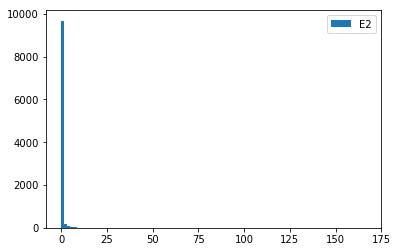

In [6]:
E, E_first, E_second = np.zeros(10000), np.zeros(10000), np.zeros(10000)

for i in range(10000):
    E[i] = np.exp(data[i][14][14]) +  np.exp(data[i][15][14]) + np.exp(data[i][14][15]) + np.exp(data[i][15][15])
    for j in range(4):
        for k in range(4):
            if (j == 0 or j == 3 or k == 0 or k == 3):
                 E_first[i] += np.exp(data[i][13+j][13+k])
            if (j == 0 or j == 7 or k == 0 or k == 7):
                 E_second[i] += np.exp(data[i][11+j][11+k])
                    
plt.hist(E, 100, label='E0')
plt.legend(loc='best')
plt.show()
plt.hist(E_first, 100, label='E1')
plt.legend(loc='best')
plt.show()
plt.hist(E_second, 100, label='E2')
plt.legend(loc='best')
plt.show()

In [5]:
from __future__ import print_function, division
from IPython import display

from keras.layers import Input, Dense, Reshape, Flatten, Dropout, InputLayer
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, UpSampling3D, Conv2D, Deconv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras import backend as K

import sys

import tensorflow as tf

Using TensorFlow backend.


epoch 1650


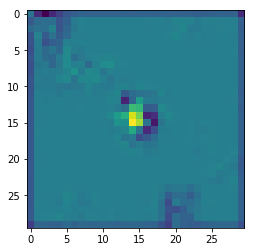

KeyboardInterrupt: 

In [11]:
class DCGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 30
        self.img_cols = 30
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(100,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 5 * 5, activation="relu", input_shape=(self.latent_dim,)))
        model.add(Reshape((5, 5, 128)))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D(size=(3, 3)))
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

#        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))

        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

#        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, save_interval=50):
        # Rescale -1 to 1
        X_train = tanh_data
        #X_train = (X_train.astype(np.float32) - 127.5)/127.5
        X_train = np.expand_dims(X_train, axis=3)

        half_batch = int(batch_size / 2)

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]

            # Sample noise and generate a half batch of new images
            noise = np.random.normal(0, 1, (half_batch, 100))
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Sample generator input
            noise = np.random.normal(0, 1, (batch_size, 100))

            # Train the generator (wants discriminator to mistake images as real)
            g_loss = self.combined.train_on_batch(noise, np.ones((batch_size, 1)))

            # Plot the progress
            #print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)
                
    

    def save_imgs(self, epoch):
        display.clear_output()
        print("epoch", epoch)
        noise = np.random.normal(0, 1, (1, 100))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
#        gen_imgs = 0.5 * gen_imgs + 1
#        fig, axs = plt.subplots(1, 1, figsize=(7,7))
        plt.imshow(np.arctanh(gen_imgs[0, :,:,0]))
        plt.show()
#        plt.close()


if __name__ == '__main__':
    dcgan = DCGAN()
    dcgan.train(epochs=50000, batch_size=32, save_interval=50)